In [8]:
# Imports
import psi4
import numpy as np
import pandas as pd
psi4.set_memory('500 MB')
from urllib.request import urlopen
import matplotlib.pyplot as plt
from matplotlib import cm
from sympy import *
from scipy import integrate

# Formatting plots
plt.rc('font', size=12)         # controls default text sizes
plt.rc('axes', titlesize=20)    # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)   # fontsize of the tick labels
plt.rc('ytick', labelsize=12)   # fontsize of the tick labels
plt.rc('legend', fontsize=20)   # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

# Ground State Energies

In [9]:
element_list = ["He", "Li", "Be", "B", "C", "N", "O", "F", "Ne"]
N_elec_dict = {"H":1, "He":2, "Li":3, "Be":4, "B":5, "C":6, "N":7, "O":8, "F":9, "Ne":10}
first_order_dict = {"He": 5/8,
                "Li":5965/5832, 
                  "Be":1/1679616 * (2813231 - 5*np.sqrt(1509308377)), 
                  "B":1/6718464 * (16493659 - np.sqrt(733174301809)), 
                  "C":(3806107/1119744 - np.sqrt(221876564389)/3359232), 
                  "N":2437421/559872, 
                  "O":4754911/839808, 
                  "F":11982943/1679616, 
                  "Ne":2455271/279936}

# Experiemental energy
experiment_dict = {"He":-5.806771753, "Li":-14.95595772, "Be":-29.336884, "B":-49.31619,
           "C":-75.71157, "N":-109.22323, "O":-150.21968, "F":-199.6142, "Ne":-258.1049} # In Rydbergs (1Ry = 0.5Ha)
experiment_energy = np.fromiter(experiment_dict.values(), dtype=float) / 2

# 1st order PT model energy
PT_dict = {"He":-2.75, "Li":-7.0566, "Be":-13.7629, "B":-22.7374,
           "C":-34.4468, "N":-49.1503, "O":-66.7048, "F":-87.6660, "Ne":-112.2917}
PT_energy = np.fromiter(PT_dict.values(), dtype=float)

# Variational PT energy
var_energy = np.zeros(len(element_list))
for i, element in enumerate(element_list):
    coeff1 = 2 + (N_elec_dict[element]-2)/4
    coeff2 = first_order_dict[element]
    var_energy[i] = -coeff1/2 * (N_elec_dict[element] - coeff2/coeff1)**2

# Hartree-Fock energy
HF_STO3G_energy = np.zeros(len(element_list)) # STO-3G basis
HF_CC_energy = np.zeros(len(element_list)) # cc-pVQZ basis

psi4.set_options({'reference': 'rohf'})

for i, element in enumerate(element_list):
    psi4.geometry(element)
    HF_STO3G_energy[i] = psi4.energy('scf/sto-3g')
    HF_CC_energy[i] = psi4.energy('scf/cc-pvqz')

In [10]:
energy_all = np.stack((PT_energy, var_energy, HF_STO3G_energy, HF_CC_energy, experiment_energy), axis=1)
gs_energy_df = pd.DataFrame(data=np.round(energy_all,4), index=element_list, 
                            columns=["1st order PT", "Variational", "HF (STO-3G)", "HF (CC-PVQZ)", "Experiment"])
gs_energy_df

,1st order PT,Variational,HF (STO-3G),HF (CC-PVQZ),Experiment
He,-2.7500,-2.8477,-2.8079,-2.8615,-2.9034
Li,-7.0566,-7.2891,-7.3156,-7.4327,-7.4780
Be,-13.7629,-14.2492,-14.3520,-14.5730,-14.6684
B,-22.7374,-23.7223,-24.1491,-24.5290,-24.6581
C,-34.4468,-36.2168,-37.0897,-37.6043,-37.8558
N,-49.1503,-52.0662,-53.5547,-54.2630,-54.6116
O,-66.7048,-71.2844,-73.6619,-74.6897,-75.1098
F,-87.6660,-94.4525,-97.9866,-99.4090,-99.8071
Ne,-112.2917,-121.9076,-126.6046,-128.5435,-129.0524


In [11]:
PT_error = (experiment_energy - PT_energy) / experiment_energy * 100
var_error = (experiment_energy - var_energy) / experiment_energy * 100
HF_error = (experiment_energy - HF_STO3G_energy) / experiment_energy * 100
HFCC_error = (experiment_energy - HF_CC_energy) / experiment_energy * 100
energy_error_df =  pd.DataFrame(data=np.round(np.stack((PT_error, var_error, HF_error, HFCC_error, ),
                                                       axis=1),1), index=element_list, 
                            columns=["1st order PT", "Variational", "HF (STO-3G)", "HF (CC-PVQZ)"])
energy_error_df

,1st order PT,Variational,HF (STO-3G),HF (CC-PVQZ)
He,5.3,1.9,3.3,1.4
Li,5.6,2.5,2.2,0.6
Be,6.2,2.9,2.2,0.7
B,7.8,3.8,2.1,0.5
C,9.0,4.3,2.0,0.7
N,10.0,4.7,1.9,0.6
O,11.2,5.1,1.9,0.6
F,12.2,5.4,1.8,0.4
Ne,13.0,5.5,1.9,0.4


# Energy Large Z

The atom and geometry for Psi4 is initialized for neutral atoms with `psi4.geometry(element)`, where element is the element symbol, e.g. Li for Lithium.

When we wish to increase the nuclear charge $Z$, while keeping the number of electrons the same, we also have to include the ionic charge and multiplicity of the atom as strings, as well as changing the element symbol:
`psi4.geometry(charge multiplicity \n element)`
For a positively charged ion, the charge is just the nuclear charge Z minus the number of electrons. The multiplicity is 1 if the atom is closed-shell, and 2 if the atom has at least one unpaired electron.

In [12]:
element_list_extended = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne",
                          "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca",
                         "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
                         "Ga", "Ge", "As", "Se", "Br", "Kr"]
N_elec_dict = {"H":1, "He":2, "Li":3, "Be":4, "B":5, "C":6, "N":7, "O":8, "F":9, "Ne":10}
first_order_dict = {"He": 5/8,
                "Li":5965/5832, 
                  "Be":1/1679616 * (2813231 - 5*np.sqrt(1509308377)), 
                  "B":1/6718464 * (16493659 - np.sqrt(733174301809)), 
                  "C":(3806107/1119744 - np.sqrt(221876564389)/3359232), 
                  "N":2437421/559872, 
                  "O":4754911/839808, 
                  "F":11982943/1679616, 
                  "Ne":2455271/279936}

def iso_hf_pt(iso_element, hf_basis="sto-3g", show_plots=True, return_vals=False):
    N_elec = N_elec_dict[iso_element]
    HF_iso_energy = np.zeros(len(element_list_extended[N_elec-1:]))
    
    for i, element in enumerate(element_list_extended[N_elec-1:]):
        psi4.geometry(str(i) + " " + str(1+ N_elec%2) + "\n" + element)
        psi4.set_options({'reference': 'rohf'})
        try:
            HF_iso_energy[i] = psi4.energy('scf/{}'.format(hf_basis))
        except:
            HF_iso_energy[i] = "NaN"
    def PT_Z(Z):
        e_coeff1 = -1 - (N_elec-2)/8
        e_coeff2 = first_order_dict[iso_element]
        return e_coeff1*Z**2 + e_coeff2*Z
    Z_vals = np.arange(N_elec, len(element_list_extended) + 1)
    PT_iso_energy = PT_Z(Z_vals)

    if show_plots == True:
        fig, ax = plt.subplots(1, 2, figsize=(16,6))
        ax[0].plot(1/Z_vals, PT_iso_energy/Z_vals**2, '-o', label="PT")
        ax[0].plot(1/Z_vals, HF_iso_energy/Z_vals**2, '-o', label="HF")

        ax[0].legend()
        ax[0].set_xlabel("1/Z")
        ax[0].set_ylabel(r"Energy/$Z^2$ (Hartrees)")
        ax[0].set_title(iso_element + " Isoelectronic sequence")

        ax[1].plot(Z_vals, HF_iso_energy-PT_iso_energy, '-o', color="tab:red", label="PT")
        ax[1].hlines(0, Z_vals[0], Z_vals[-1], color='grey', linestyle='dashed')
        ax[1].set_xlabel("Z")
        ax[1].set_ylabel(r"Energy (Hartrees)")
        ax[1].set_title("Difference between HF and PT")
        plt.show()
        
    if return_vals == True:
        return PT_iso_energy, HF_iso_energy, Z_vals

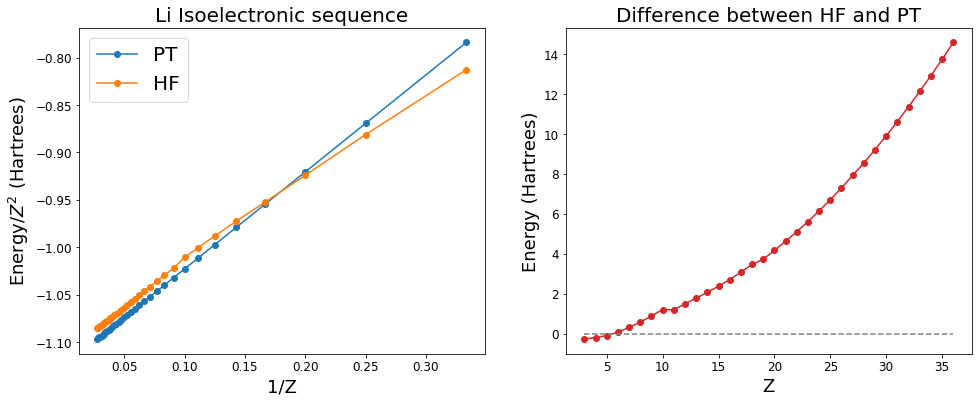

In [13]:
iso_hf_pt("Li")

# Energy Level Spectral Gaps

In [14]:
def spectral_gaps_plot(element, max_shell, max_Z, PT_vs, term_order, ax):
    """
    Plot the spectral gaps for a certain isoelectronic sequence and its energy levels.
    For lower Z, experimental data are plotted. For higher Z, the PT energy gaps are plotted.

    Input:
    element: Element symbol string of isoelectronic sequence to look at
    max_shell: The maximum number n of the shell to include in energies
    max_Z: Maximum Z charge to go to for experimental values
    PT_vs: PT model first order correction coefficients list for element
    term_order: list of term symbol strings in order of energy level for element
    ax: axis on which to plot
    """
    element_list = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne",
                    "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca",
                    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
                    "Ga", "Ge", "As", "Se", "Br", "Kr"]
    element_Z = element_list.index(element) + 1 # Z charge of the first element in isoelectronic sequence
    max_level = np.shape(PT_vs)[0] # highest energy level to include
    all_levels = np.empty((max_level, max_Z-element_Z+1)) # to store all energy level gap data
    
    # Loop over ion charges
    for add_Z in range(max_Z-element_Z+1):
        current_element = element_list[element_Z-1 + add_Z] # isoelectronic sequence element symbol names

        # Scrape experimental data from NIST into dataframe
        u = "https://physics.nist.gov/cgi-bin/ASD/energy1.pl?de=0&spectrum=" + current_element + str(add_Z) + "&units=2&format=2&output=0&page_size=15&multiplet_ordered=0&conf_out=on&term_out=on&level_out=on&unc_out=1&j_out=on&lande_out=on&perc_out=on&biblio=on&temp=&submit=Retrieve+Data"
        energy_txt = urlopen(u)
        df = pd.read_csv(energy_txt)[["Configuration", "Term", "Level (Ry)"]]

        # Discard all (annoying) irrelevant characters
        df = df.replace(to_replace=['=', '"', '\+', 'x', 'y', 'w', 'z', '\?', '&dagger;', '\[', ']'], value="", regex=True)
        df[["Level (Ry)", "Term"]] = df[["Level (Ry)", "Term"]].replace(to_replace=['a', 'e', '\(', '\)'], value="", regex=True)
        df = df.replace(" ", np.nan)
        df = df.dropna(subset = ["Level (Ry)"]).reset_index()
        # Convert energies to floats
        try:
            df = df.astype({'Level (Ry)': 'float64'})
        except:
            print("Cannot convert to float. Currently on:{}, {}".format(current_element, add_Z))
        
        # Loop over energy levels
        level = 0
        i = 0
        element_levels = pd.DataFrame(columns = ["Term", "Level"])
        while (level < max_level):
            if i < len(df):
                # Get max shell number of configuration
                config = df["Configuration"].iloc[i]
                if "." not in config:
                    check = config[0]
                elif config.split(".")[-1][0] == "(":
                    check = config.split(".")[-2][0]
                else:
                    check = config.split(".")[-1][0] 

                # Check if electron configuration has the right max shell number
                if check == str(max_shell): 

                    # Some exceptions for term ordering
                    if element == "Be" and add_Z == 0:
                        term_order_check = ["1S", "3P*", "1P*", "1D", "3P", "1S"]
                    elif element == "C" and add_Z == 14:
                        term_order_check = C_term_order = ["3P", "1D", "1S", "5S*", "3D*", "3P*", "3S*", "1D*", "1P*", "3P", "1D", "1S"]
                    else:
                        term_order_check = term_order # normal term ordering
                    
                    # Check if term symbols match up
                    term = df["Term"].iloc[i] # term symbol to check
                    if term == term_order_check[level]:
                        # If yes then add scaled spectral gap to dataframe
                        element_levels = element_levels.append({"Term":term, 
                                                            "Level":df["Level (Ry)"].iloc[i]/(2*((element_Z +add_Z)**2))}, 
                                                           ignore_index=True)
                        level += 1

                    # Some exceptions for missing data
                    elif element == 'Be' and add_Z == 14 and level == 4:
                        element_levels = element_levels.append({"Term":term, "Level":"NaN"}, ignore_index=True)
                        level += 1
                    elif element == 'O' and add_Z == 9 and level == 4:
                        element_levels = element_levels.append({"Term":term, "Level":"NaN"}, ignore_index=True)
                        level += 1

            # If level is too large for experimental data, make all the remaining levels NaN
            else:
                term = term_order[level]
                element_levels = element_levels.append({"Term":term, "Level": "NaN"}, ignore_index=True)
                level += 1
            i += 1
        
        # Some exceptions for particular cases with different order of energy levels
        if element == "Be" and add_Z == 0:
            element_levels = element_levels.reindex([0,1,2,4,3,5])
        if element == "C" and add_Z == 14:
            element_levels = element_levels.reindex([0,1,2,3,4,5,7,6,8,9,10,11])
        if element == "F" and add_Z == 16:
            element_levels.loc[1] = "NaN"
            
        all_levels[:,add_Z] = element_levels["Level"] # add to full data matrix

    Z_vals_exp = np.arange(element_Z, max_Z+1) # Z values for experimental data
    
    # Loop over energy levels to plot experimental data and PT energy for larger Z
    cols = [i for i in cm.get_cmap('tab20').colors] # to cycle through colours
    for i in range(max_level):
        ax.plot([0, 1/(max_Z+2)], [0, (PT_vs[i]-PT_vs[0])/(max_Z+2)], '-', color=cols[i])
        ax.plot(1/Z_vals_exp, all_levels[i,:], 'o-',  color=cols[i])
    ax.set_xlabel("$1/Z$")
    ax.set_ylabel(r"Spectral Gap/$Z^2$")
    ax.set_title("{} isoelectronic sequence spectral gaps".format(element))
    return ax

In [15]:
# Data is from Friesecke, G. and Goddard, B., 2009. SIAM Journal on Mathematical Analysis, 41(2), pp.631-664

Li_PT_vs = [5965/5832, 57397/52488]
Be_PT_vs = [(2813231-5*np.sqrt(1509308377))/1679616,
            1363969/839808,
            2826353/1679616,
            1449605/839808,
            14673197/8398080,
            (2813231+5*np.sqrt(1509308377))/1679616]
B_PT_vs = [(16493659 - np.sqrt(733174301809))/6718464,
           2006759/839808,
           40981549/16796160,
           4151299/1679616,
           8322281/3359232,
           706213/279936,
           14301407/5598720,
           (16493659 + np.sqrt(733174301809))/6718464]
C_PT_vs = [(3806107/1119744 - np.sqrt(221876564389)/3359232),
             19148633/5598720 - np.sqrt(221876564389)/3359232,
             966289/279936 - np.sqrt(62733275266)/1679616,
             464555/139968,
             4730843/1399680,
             1904147/559872,
             9625711/2799360,
             961915/279936,
             242119/69984,
             3806107/1119744 + np.sqrt(221876564389)/3359232,
             19148633/5598720 + np.sqrt(221876564389)/3359232,
             966289/279936 + np.sqrt(62733275266)/1679616]
N_PT_vs = [2437421/559872,
            24551357/5598720,
            (30636167-np.sqrt(1144203315841))/6718464,
            7549145/1679616,
            76337819/16796160,
            3843463/839808,
           15393535/3359232,
           (30636167+np.sqrt(1144203315841))/6718464]
O_PT_vs = [4754911/839808,
           47726257/8398080,
           (9884485-np.sqrt(89111336179))/1679616,
           1224899/209952,
           9897607/1679616,
           (9884485+np.sqrt(89111336179))/1679616]
F_PT_vs = [11982943/1679616, 4108267/559872]

Li_term_order = ["2S", "2P*"]
Be_term_order = ["1S", "3P*", "1P*", "3P", "1D", "1S"]
B_term_order = ["2P*", "4P", "2D", "2S", "2P", "4S*", "2D*", "2P*"]
C_term_order = ["3P", "1D", "1S", "5S*", "3D*", "3P*", "1D*", "3S*", "1P*", "3P", "1D", "1S"]
N_term_order = ["4S*", "2D*", "2P*", "4P", "2D", "2S", "2P", "2P*"]
O_term_order = ["3P", "1D", "1S", "3P*", "1P*", "1S"]
F_term_order = ["2P*", "2S"]

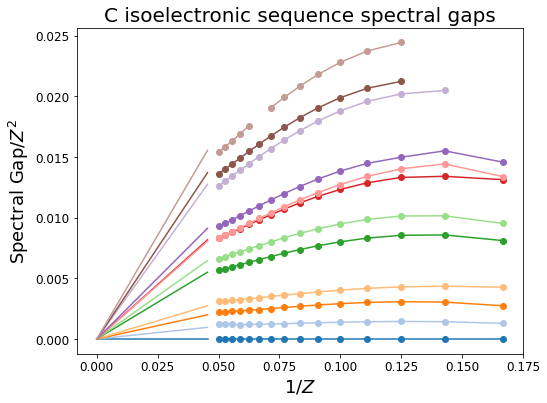

In [16]:
## Carbon example

fig, ax = plt.subplots(figsize=(8,6))
ax = spectral_gaps_plot(element="C", max_shell=2, max_Z=20, PT_vs=C_PT_vs, term_order=C_term_order, ax=ax)
plt.show()

# Wave Functions

In [17]:
# Hydrogen-like one-electron wave functions
def H_wfns(r, Z, orb):
    if orb == 1: #1s
        return Z**(3/2) / np.sqrt(np.pi) * np.exp(-Z*r)
    if orb == 2: #2s
        return Z**(3/2) / np.sqrt(8*np.pi) * (1-Z*r/2)*np.exp(-Z*r/2)
    if orb == 3: #2p radial part
        return r*Z**(5/2) / np.sqrt(32*np.pi) * np.exp(-Z*r/2)
    
    
def get_PT_density(Z, N_elec, slater_list, slater_coeff):
    """
    Return a function for the normalized PT model wave function density

    Input:
    Z: nuclear charge
    N_elec: number of electrons
    slater_list: nested list of slater determinants and the orbitals they contain
    slater_coeff: list of coefficients if there are multiple slater determiants
    """
    # Get the density as a function of radius r
    def density(r):
        total = 0
        for i, slater in enumerate(slater_list):
            total_slater = 0
            for orb in slater:
                total_slater += H_wfns(r=r, Z=Z, orb=orb)**2
            total += slater_coeff[i]**2 * total_slater
        return total*r**2
    
    # Normalize density
    norm = integrate.quad(density, 0, np.inf)[0]
    def density_norm(r):
        return density(r)/norm * N_elec
    
    return density_norm


def get_HF_density(element, Z):
    """
    Return a function for the normalized ROHF with STO-3G basis wave function density
    This works for first 4 elements (1s to 2s subshells)

    Input:
    element: element symbol as a string
    Z: nuclear charge
    """
    
    N_elec_dict = {"H":1, "He":2, "Li":3, "Be":4}
    
    element_list = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne",
                   "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca",
                   "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
                   "Ga", "Ge", "As", "Se", "Br", "Kr"]
    
    N_elec = N_elec_dict[element]
    
    # Get Psi4 wave function output and basis information
    psi4.geometry(str(Z - N_elec) + " " + str(1 + N_elec%2) + "\n" + element_list[Z-1])
    psi4.set_options({'reference': 'rohf'})
    hf_energy, hf_wf = psi4.energy('scf/sto-3g', return_wfn=True)
    hf_basis = hf_wf.basisset()
    
    # Alpha and beta coefficent matrices
    Ca = hf_wf.Ca().to_array()[0]
    Cb = hf_wf.Cb().to_array()[0]
    
    # Tuples with number of electrons in each alpha, beta orbital 
    n_alpha = sum(hf_wf.nalphapi().to_tuple())
    n_beta = sum(hf_wf.nbetapi().to_tuple())

    n_guass = hf_basis.max_nprimitive() # number of primitive Gaussian functions per orbital
    
    # Get the density as a function of radius r
    def density(r):
        total = 0
        for j in range(n_alpha):
            total_orb = 0
            for i in range(n_alpha):
                total_gauss = 0
                for k in range(n_guass):
                    coeff = hf_basis.shell(i).coef(k)
                    exp_coeff = hf_basis.shell(i).exp(k)
                    total_gauss += coeff*np.exp(-exp_coeff*r**2)
                total_orb += Ca[i,j]*total_gauss
            total += total_orb**2
            
        for j in range(n_beta):
            total_orb = 0
            for i in range(n_alpha):
                total_gauss = 0
                for k in range(n_guass):
                    coeff = hf_basis.shell(i).coef(k)
                    exp_coeff = hf_basis.shell(i).exp(k)
                    total_gauss += coeff*np.exp(-exp_coeff*r**2)
                total_orb += Cb[i,j]*total_gauss
            total += total_orb**2
        return total*r**2
    
    # Normalize wavefunction
    norm = integrate.quad(density, 0, np.inf)[0]
    def density_norm(r):
        return density(r)/norm * N_elec
    
    return density_norm

# Plot both HF and PT radial probabilities
def plot_hf_pt_radial(element, Z, ax, HF=True, PT=True):
    rs = np.linspace(0,5,10000)
    
    Be_c = -np.sqrt(3)/59049 * (2*np.sqrt(1509308377) - 69821) 
    slater_list_dict = {"H":[[1]], "He":[[1,1]], "Li": [[1,1,2]], "Be": [[1,1], [2,2], [3,3]]}
    slater_coeff_dict = {"H":[1], "He": [1], "Li": [1], "Be": [1, 1/np.sqrt(1+Be_c**2), Be_c/np.sqrt(1+Be_c**2)]}
    elec_dict = {"H":1, "He":2, "Li":3, "Be":4}
    
    if PT == True:
        pt_density = get_PT_density(Z=Z, N_elec=elec_dict[element], slater_list = slater_list_dict[element], slater_coeff = slater_coeff_dict[element])
        ax.plot(rs, pt_density(rs), label="PT, Z={}".format(Z))

    if HF == True:
        hf_denisty = get_HF_density(element=element, Z=Z)
        ax.plot(rs, hf_denisty(rs), label="HF, Z={}".format(Z))
    
    ax.set_xlabel(r"$r$ (atomic units)")
    ax.set_ylabel(r"$\rho r^2$")
    ax.set_title("{} Radial Probability".format(element))
    ax.set_xlim([0,5])
    ax.legend()
    return ax

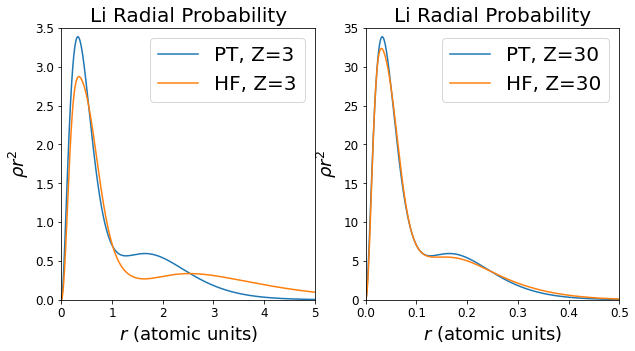

In [18]:
# Example with Lithium
fig, ax = plt.subplots(1, 2, figsize=(10 ,5))
ax[0] = plot_hf_pt_radial("Li", 3, ax=ax[0]) # Z=3
ax[0].set_ylim(0,3.5)
# plt.show()

# fig, ax = plt.subplots(figsize=(5,5))
ax[1] = plot_hf_pt_radial("Li", 30, ax=ax[1]) # Z=30
ax[1].set_xlim([0, 0.5])
ax[1].set_ylim([0, 35])
plt.show()

### Increasing Z

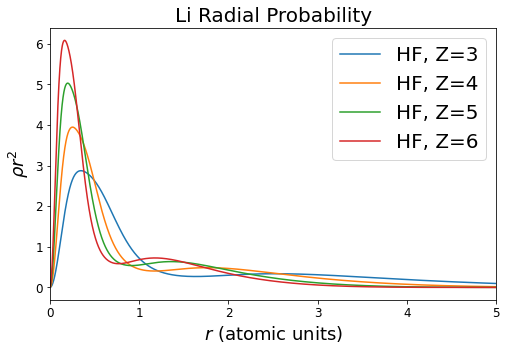

In [19]:
# To show effect of increasing Z on wave function
fig, ax = plt.subplots(figsize=(8,5))
for z in [3, 4, 5, 6]:
    ax = plot_hf_pt_radial("Li", z, ax=ax, PT=False)
plt.show()

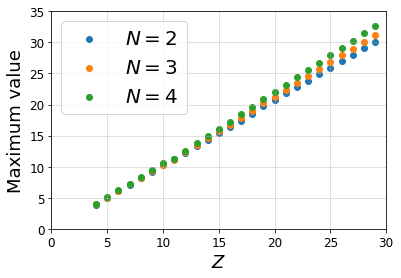

In [20]:
### Find modes heights ###
rs = np.linspace(0,5,10000)
Zs = np.arange(4, 30)
for i, element in enumerate(["He", "Li", "Be"]):
    heights = []

    for Z in Zs:
        wfn = get_HF_density(element=element, Z=Z)(rs)
        heights.append(np.max(wfn))

    plt.scatter(Zs, heights, label="$N=$" + str(i+2))

plt.xlabel("$Z$")
plt.ylabel("Maximum value")
plt.xlim(0,30)
plt.ylim(0,35)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

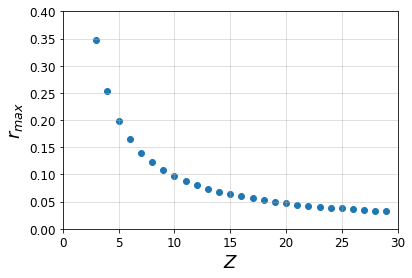

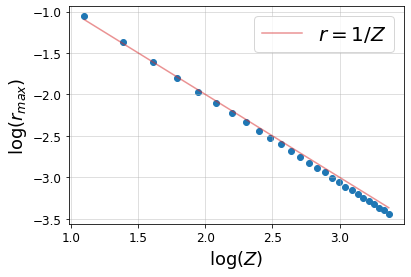

In [21]:
### Find mode locations ### 
rs = np.linspace(0,5,10000)
Zs = np.arange(3, 30)
modes = []

for Z in Zs:
    wfn = get_HF_density(element="Li", Z=Z)(rs)
    modes.append(rs[np.argmax(wfn)])

plt.scatter(Zs, modes)
plt.xlabel("$Z$")
plt.ylabel("$r_{max}$")
plt.xlim([0,30])
plt.ylim([0,0.4])
plt.grid(alpha=0.5)
plt.show()

plt.plot(np.log(Zs), np.log(1/Zs), color="tab:red", alpha=0.5, label="$r=1/Z$")
plt.scatter(np.log(Zs), np.log(modes))
plt.xlabel("$\log(Z)$")
plt.ylabel("$\log(r_{max})$")
plt.legend()
plt.grid(alpha=0.5)
plt.show()